In [1]:
import sys
sys.path.append("../")

In [4]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import torch
import torch.nn.functional as F
from torch_scatter import scatter_add

from src.bfsenv import State, BatchedState, GraphBuildingEnv, MolGraph
from src.models import GraphEmbedding, GraphPolicy, EnergyModel
from src.random_graph import grid_graph, binomial_tree_graph

In [5]:
@torch.no_grad()
def sample_termial(model, size, max_step):
    model.eval()
    states = env.BatchedState([env.initial_state() for _ in range(size)])
    done_states = env.BatchedState()

    for _ in range(max_step):
        fwd_dist = model.forward_action(states)
        actions = fwd_dist.sample()
        next_states = []
        for s, a in zip(states, actions):
            s_ = env.step(s, a)

            if s_.state_type == env.StateType.Terminal:
                done_states.add(s_)
            else:
                next_states.append(s_)

        states = env.BatchedState(next_states)
        if states.total_size == 0:
            break

    for s in states:
        s.terminate()
        done_states.add(s)
        
    return done_states


def energy_loss(pos_x, neg_x, alpha=0.1):
    pos_out = energy(pos_x)
    neg_out = energy(neg_x)

    loss = pos_out - neg_out
    reg = pos_out.square() + neg_out.square()
    
    return loss.mean() + alpha * reg.mean()
    
@torch.no_grad()
def log_reward(sample):
    return - energy(sample)
    
def tb_loss(samples: BatchedState, logR: torch.Tensor): # logZ
    traj = env.state_to_trajectory(samples)
    
    fwd_act = model.forward_action(traj.get_states())
    log_pf_s = fwd_act.log_prob(traj.get_actions())
    t_idx = torch.repeat_interleave(traj.get_length())
    log_pf = scatter_add(log_pf_s, t_idx)
    
    bwd_act = model.backward_action(samples)
    log_pb = bwd_act.log_prob(samples.get_node_order())
        
    loss = (logZ + log_pf - log_pb - logR).square().mean()
    return loss


env = GraphBuildingEnv(1, 1, max_degree=4)


model = GraphPolicy(GraphEmbedding(env))
energy = EnergyModel(GraphEmbedding(env))
logZ = torch.nn.Parameter(torch.tensor(0.0))

optimizer = torch.optim.Adam(
    list(model.parameters())
    +list(energy.parameters())
    +[logZ]
)

In [7]:
import tqdm
from IPython import display
from collections import defaultdict

size = 8
max_step = 40



losses = []
# pbar = tqdm.trange(1000)
pbar = range(1000)
for i in pbar:
    # sampling
    neg_x = sample_termial(model, size, max_step)
    pos_x = binomial_tree_graph(size=size)
    
    pos_x.set_node_order(model.backward_action(pos_x).sample())
    
    neg_logR = log_reward(neg_x)
    pos_logR = log_reward(pos_x)
        
    # update: GFN
    floss = tb_loss(neg_x, neg_logR) + tb_loss(pos_x, pos_logR)
    
    eloss = energy_loss(pos_x, neg_x)
    
    loss = floss + eloss

    optimizer.zero_grad()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    torch.nn.utils.clip_grad_norm_(energy.parameters(), 1.0)
    optimizer.step()
    
#     if i % 5 == 0:
        # update: energy
#         optimizer.zero_grad()
#         eloss.backward()
#         torch.nn.utils.clip_grad_norm_(energy.mlp.parameters(), 1.0)
#         optimizer.step()
        
    if i % 5 == 0:
        rank = torch.argsort(neg_logR)
        
        plt.figure(figsize=(8, 5))
        for k in range(8):
            r = rank[k].item()
            ax = plt.subplot(2, 4, k+1)
            plt.title(str(round(neg_logR[r].exp().item(), 4)))
            neg_x[r].visualize(figsize=None, ax=ax)
            plt.axis("off")
        plt.show()
        print(i)
        display.clear_output(wait=True)
        

    # logging
    loss_info = {
        "floss": floss.item(), 
         "eloss": eloss.item(),
         "logR":neg_logR.mean().item(),
         "logZ":logZ.item()
    }
#     pbar.set_postfix(loss_info)

    losses.append(loss_info)
    
history = pd.DataFrame(losses)

KeyboardInterrupt: 

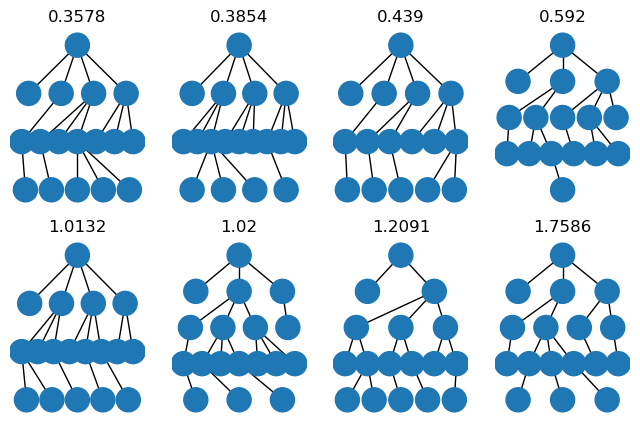

182


In [17]:
neg_x = sample_termial(model, size, max_step)
neg_logR = log_reward(neg_x)
rank = torch.argsort(neg_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    plt.title(str(round(neg_logR[r].exp().item(), 4)))
    neg_x[r].visualize(figsize=None, ax=ax, bfs_root=1)
    plt.axis("off")
plt.show()
print(i)

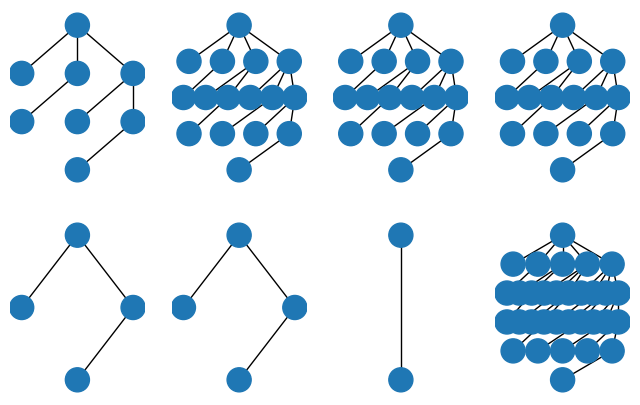

In [16]:
pos_logR = log_reward(pos_x)
rank = torch.argsort(pos_logR)

plt.figure(figsize=(8, 5))
for k in range(8):
    r = rank[k].item()
    ax = plt.subplot(2, 4, k+1)
    # plt.title(str(round(pos_logR[r].exp().item(), 4)))
    pos_x[r].visualize(figsize=None, ax=ax, bfs_root=0)
    plt.axis("off")
plt.show()